In [ ]:
!pip install tensorflow

In [ ]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2024-10-07 19:13:32--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  12.1MB/s    in 0.4s    

2024-10-07 19:13:32 (12.1 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]



In [ ]:
!mkdir -p data && unzip spa-eng.zip -d data

Archive:  spa-eng.zip
  inflating: data/_about.txt         
  inflating: data/spa.txt            


In [1]:
import string
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy


# Path to translation file
path_to_data = 'data/spa.txt'

# Read file
translation_file = open(path_to_data,"r", encoding='utf-8')
raw_data = translation_file.read()
translation_file.close()

# Parse data
raw_data = raw_data.split('\n')
pairs = [sentence.split('\t') for sentence in  raw_data]
pairs = pairs[1000:20000]

In [ ]:
def clean_sentence(sentence):
    # Lower case the sentence
    lower_case_sent = sentence.lower()
    # Strip punctuation
    string_punctuation = string.punctuation + "¡" + '¿'
    clean_sentence = lower_case_sent.translate(str.maketrans('', '', string_punctuation))

    return clean_sentence

In [ ]:
def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer()
    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [ ]:
# Clean sentences
english_sentences = [clean_sentence(pair[0]) for pair in pairs]
spanish_sentences = [clean_sentence(pair[1]) for pair in pairs]

# Tokenize words
spa_text_tokenized, spa_text_tokenizer = tokenize(spanish_sentences)
eng_text_tokenized, eng_text_tokenizer = tokenize(english_sentences)

print('Maximum length spanish sentence: {}'.format(len(max(spa_text_tokenized,key=len))))
print('Maximum length english sentence: {}'.format(len(max(eng_text_tokenized,key=len))))


# Check language length
spanish_vocab = len(spa_text_tokenizer.word_index) + 1
english_vocab = len(eng_text_tokenizer.word_index) + 1
print("Spanish vocabulary is of {} unique words".format(spanish_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))

Maximum length spanish sentence: 9
Maximum length english sentence: 5
Spanish vocabulary is of 7262 unique words
English vocabulary is of 3718 unique words


In [ ]:
max_spanish_len = int(len(max(spa_text_tokenized,key=len)))
max_english_len = int(len(max(eng_text_tokenized,key=len)))

spa_pad_sentence = pad_sequences(spa_text_tokenized, max_spanish_len, padding = "post")
eng_pad_sentence = pad_sequences(eng_text_tokenized, max_english_len, padding = "post")

# Reshape data
spa_pad_sentence = spa_pad_sentence.reshape(*spa_pad_sentence.shape, 1)
eng_pad_sentence = eng_pad_sentence.reshape(*eng_pad_sentence.shape, 1)

In [ ]:
input_sequence = Input(shape=(max_spanish_len,))
embedding = Embedding(input_dim=spanish_vocab, output_dim=128,)(input_sequence)
encoder = LSTM(64, return_sequences=False)(embedding)
r_vec = RepeatVector(max_english_len)(encoder)
decoder = LSTM(64, return_sequences=True, dropout=0.2)(r_vec)
logits = TimeDistributed(Dense(english_vocab))(decoder)

In [ ]:
enc_dec_model = Model(input_sequence, Activation('softmax')(logits))
enc_dec_model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(1e-3),
              metrics=['accuracy'])
enc_dec_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 9, 128)              │         929,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 5, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 3718)             │         241,670 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 5, 3718)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,253,638 (4.78 MB)

 Trainable params: 1,253,638 (4.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_results = enc_dec_model.fit(spa_pad_sentence, eng_pad_sentence, batch_size=30, epochs=100)


Epoch 1/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3461 - loss: 5.2130
Epoch 2/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3890 - loss: 4.0030
Epoch 3/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3915 - loss: 3.8975
Epoch 4/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3928 - loss: 3.8343
Epoch 5/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4042 - loss: 3.6482
Epoch 6/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4284 - loss: 3.4271
Epoch 7/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4559 - loss: 3.2193
Epoch 8/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4758 - loss: 3.0276
Epoch 9/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4902 - loss: 2.8772
Epoch 10/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5071 - loss: 2.7302
Epoch 11/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5242 - loss: 2.6068
Epoch 12/100
634/634 ━━━━━━━━━━━━━━━━━

In [ ]:
def logits_to_sentence(logits, tokenizer):

    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

index = 14
print("The english sentence is: {}".format(english_sentences[index]))
print("The spanish sentence is: {}".format(spanish_sentences[index]))
print('The predicted sentence is :')
print(logits_to_sentence(enc_dec_model.predict(spa_pad_sentence[index:index+1])[0], eng_text_tokenizer))

The english sentence is: see above
The spanish sentence is: véase arriba
The predicted sentence is :
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
see above <empty> <empty> <empty>


In [ ]:
import numpy as np
import random

def logits_to_sentence(logits, tokenizer):
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

def calculate_accuracy(model, tokenizer, spanish_sentences, english_sentences, pad_sentences, n=100, max_index=3000):
    # Randomly select 100 indices within 3000 index
    random_indices = random.sample(range(max_index), n)
    correct_predictions = 0

    # Lists to store predictions and ground truths
    predictions_list = []
    groundtruths_list = []
    correctness_list = []

    for index in random_indices:
        # Get the Spanish sentence, predict, and convert logits to sentence
        predicted_sentence = logits_to_sentence(model.predict(pad_sentences[index:index+1])[0], tokenizer)

        # Get the ground truth English sentence
        ground_truth_sentence = english_sentences[index]

        # Store predictions and ground truths
        predictions_list.append(predicted_sentence.replace('<empty>', '').strip())
        groundtruths_list.append(ground_truth_sentence.strip())

        # Check if the predicted sentence matches the ground truth (ignoring <empty> tokens)
        if predictions_list[-1] == groundtruths_list[-1]:
            correctness_list.append("Correct")
            correct_predictions += 1
        else:
            correctness_list.append("Wrong")

    # Calculate accuracy
    accuracy = correct_predictions / n * 100

    # Output predictions, ground truths, and correctness
    for i, (predicted, ground_truth, correctness) in enumerate(zip(predictions_list, groundtruths_list, correctness_list)):
        print(f"Index {i+1}:")
        print(f"  Predicted: {predicted}")
        print(f"  Ground Truth: {ground_truth}")
        print(f"  Status: {correctness}")
        print()

    # Return the accuracy
    return accuracy

# Calculate accuracy for 100 random sentences within the first 3000 indices
accuracy = calculate_accuracy(enc_dec_model, eng_text_tokenizer, spanish_sentences, english_sentences, spa_pad_sentence, n=100, max_index=3000)
print(f'Accuracy: {accuracy:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

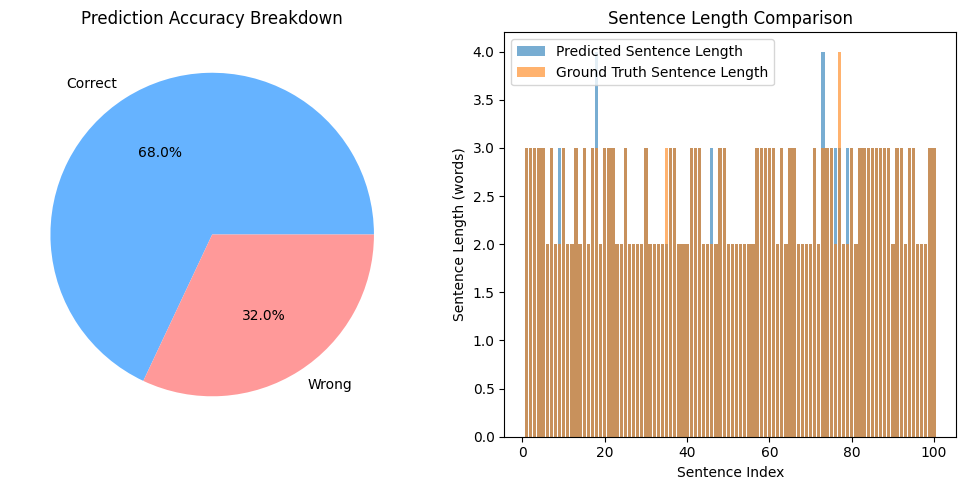

Accuracy: 68.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def logits_to_sentence(logits, tokenizer):
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

def calculate_accuracy_and_collect_data(model, tokenizer, spanish_sentences, english_sentences, pad_sentences, n=100, max_index=3000):
    # Randomly select 100 indices within 3000 index
    random_indices = random.sample(range(max_index), n)
    correct_predictions = 0

    # Lists to store predictions, ground truths, correctness, and sentence lengths
    predictions_list = []
    groundtruths_list = []
    correctness_list = []
    predicted_lengths = []
    ground_truth_lengths = []

    for index in random_indices:
        # Get the Spanish sentence, predict, and convert logits to sentence
        predicted_sentence = logits_to_sentence(model.predict(pad_sentences[index:index+1])[0], tokenizer)

        # Get the ground truth English sentence
        ground_truth_sentence = english_sentences[index]

        # Store predictions, ground truths, and lengths
        predictions_list.append(predicted_sentence.replace('<empty>', '').strip())
        groundtruths_list.append(ground_truth_sentence.strip())
        predicted_lengths.append(len(predictions_list[-1].split()))
        ground_truth_lengths.append(len(groundtruths_list[-1].split()))

        # Check if the predicted sentence matches the ground truth (ignoring <empty> tokens)
        if predictions_list[-1] == groundtruths_list[-1]:
            correctness_list.append("Correct")
            correct_predictions += 1
        else:
            correctness_list.append("Wrong")

    # Calculate accuracy
    accuracy = correct_predictions / n * 100

    # Return data
    return accuracy, correctness_list, predicted_lengths, ground_truth_lengths

# Calculate accuracy and collect data for plotting
accuracy, correctness_list, predicted_lengths, ground_truth_lengths = calculate_accuracy_and_collect_data(
    enc_dec_model, eng_text_tokenizer, spanish_sentences, english_sentences, spa_pad_sentence, n=100, max_index=3000)

# Plot the correctness breakdown (Pie chart)
correct_count = correctness_list.count("Correct")
wrong_count = correctness_list.count("Wrong")

plt.figure(figsize=(10, 5))

# Pie chart for correctness
plt.subplot(1, 2, 1)
plt.pie([correct_count, wrong_count], labels=['Correct', 'Wrong'], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Prediction Accuracy Breakdown')

# Bar chart for sentence lengths
plt.subplot(1, 2, 2)
plt.bar(range(1, 101), predicted_lengths, alpha=0.6, label='Predicted Sentence Length')
plt.bar(range(1, 101), ground_truth_lengths, alpha=0.6, label='Ground Truth Sentence Length')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length (words)')
plt.title('Sentence Length Comparison')
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}%')
